# MP-A: Song hotness prediction on million song dataset
We use song hotness as a proxy of whether a song became popular or not. We use song metadata and acoustic features from a song to predict how popular (or hot) a song is going to be, by using Linear Regression. By solving this regression problem, we can find features which contain the most predictive power for predicting the popularity of a song. As a studio, we can then focus on these features while trying to figure out whether to sign on a particular artist or not. We will also study this problem in the context of large datasets by looking at space and time performance of implementing regression in a distributed setting.

## Spark configuration

In [1]:
%%info

In [2]:
%%configure -f
{ "conf":{
          "spark.pyspark.python": "python",
          "spark.pyspark.virtualenv.enabled": "true",
          "spark.pyspark.virtualenv.type":"native",
          "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
         }
}

In [3]:
import pyspark
from pyspark.ml.feature import (OneHotEncoder, 
                                CountVectorizer, 
                                FeatureHasher,
                                StringIndexer,
                                MinMaxScaler,
                                VectorAssembler)
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
import itertools
from itertools import chain
import numpy as np
import re
import time

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1606857772713_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
sc.install_pypi_package("pandas")
sc.install_pypi_package("boto3")

In [5]:
df = spark.read.format("csv").load("s3://10805-miniproject/processed_songs_with_header.csv", 
                                   inferSchema="true", header=True)
pdf = df.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
sample_points = df.take(2)
print(sample_points)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(song_hotttnesss=0.3552855364230894, artist_id=u'ARE93YV1187B9937CC', artist_familiarity=0.5598225334045578, artist_hotttnesss=0.39148391525230825, title=u'Journey (Album Version)', artist_terms=u'world beat,celtic fusion,celtic,kraut rock,world music,folk rock,electronic,dub,world,downtempo,tribal,african,world fusion,trance,alternative rock,dance,indie rock,chill-out,ambient,female vocalist,folk,fusion,experimental,rock,acoustic,instrumental,90s,crossover,country,new age,sexy,funky,spiritual,up beat,africosmic,pixies palace,posi,british folk,inspirational,uk', artist_terms_freq=u'0.9851092397824193,0.874540748274432,0.9254884607152157,0.8235930358336482,0.9254884607152157,0.8235930358336482,1.0,0.8235930358336482,0.8663786747635207,0.8235930358336482,0.6798401450790952,0.7045573910398083,0.6473998879879258,0.8235930358336482,0.8235930358336482,0.8235930358336482,0.8235930358336482,0.6120157406651994,0.802712687477908,0.7149927137212858,0.7944148924153911,0.6695602912214449,0.7625

## Data cleaning

In [7]:
df = df.na.fill({'artist_familiarity': 0, 
                 'title': '', 
                 'artist_terms': '',
                 'continent': 'Unknown'})
df = df.filter("song_hotttnesss > 0")
df = df.drop("artist_terms_freq", "artist_terms_weight", "danceability", "energy")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
summary = df.describe().toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
summary.loc[0]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

summary                       count
song_hotttnesss              457205
artist_id                    457205
artist_familiarity           457205
artist_hotttnesss            457205
title                        457205
artist_terms                 457205
year                         457205
duration                     457205
end_of_fade_in               457205
key                          457205
key_confidence               457205
loudness                     457205
mode                         457205
mode_confidence              457205
tempo                        457205
time_signature               457205
time_signature_confidence    457205
continent                    457205
effective_length             457205
Name: 0, dtype: object

## Exploration data analysis

In [1]:
import pandas as pd
import seaborn as sns

In [25]:
subset_df = pd.read_csv("processed_songs_with_header_subset.csv")

In [26]:
print(subset_df.shape)

(10000, 23)


In [32]:
subset_df["continent"].fillna("Unknown")

0              Africa
1       North America
2                Asia
3                Asia
4       North America
            ...      
9995           Europe
9996             Asia
9997    North America
9998    North America
9999             Asia
Name: continent, Length: 10000, dtype: object

In [46]:
numeric_cols = ["song_hotttnesss", "artist_familiarity", "artist_hotttnesss",
                "loudness", "continent", "year"]

In [47]:
num_df = subset_df[numeric_cols].copy()

In [64]:
num_df[(num_df["song_hotttnesss"]>0) & (num_df["year"]>0)].describe()

,song_hotttnesss,artist_familiarity,artist_hotttnesss,loudness,year
count,5270.000000,5270.000000,5270.000000,5270.000000,5270.000000
mean,0.489164,0.618151,0.431254,-9.215523,1999.638140
std,0.155839,0.113993,0.094527,4.623937,9.688437
min,0.187731,0.000000,0.000000,-51.416000,1927.000000
25%,0.372530,0.548536,0.378184,-11.640750,1996.000000
50%,0.489174,0.613467,0.421590,-8.235000,2003.000000
75%,0.601075,0.691358,0.480690,-5.854250,2006.000000
max,1.000000,1.000000,0.911299,-0.426000,2010.000000


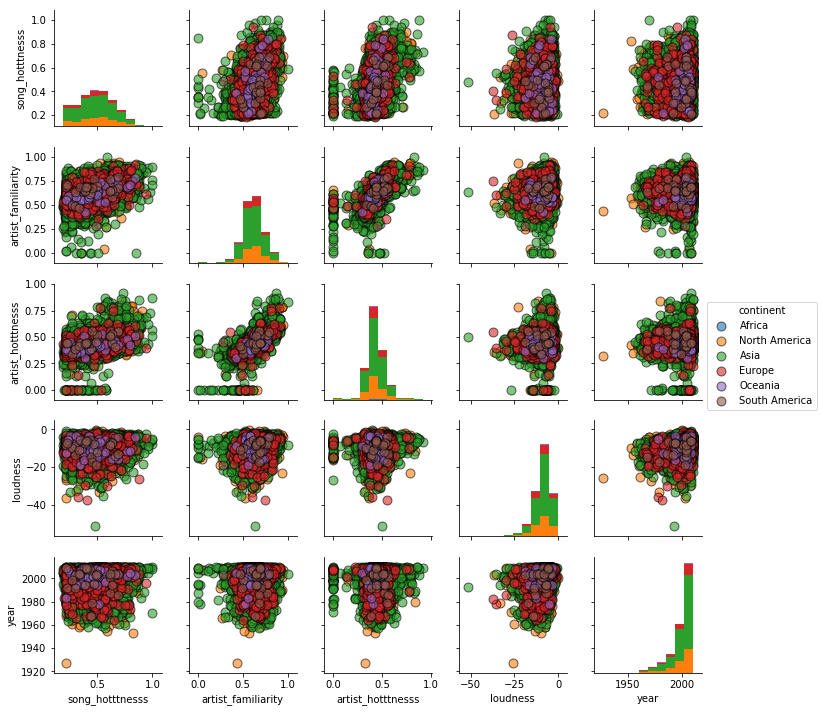

In [54]:
fig = sns.pairplot(num_df[(num_df["song_hotttnesss"]>0) & (num_df["year"]>0)], 
                 plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
                 size = 2, hue="continent")

In [62]:
fig.savefig("pairplot.png")

In [56]:
from matplotlib.backends.backend_pdf import PdfPages

In [60]:
with PdfPages('pairplot.pdf') as pdf:
    pdf.savefig(fig.fig, bbox_inches="tight")

## Feature processing pipeline

### Text cleaning

In [10]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='song_hotttnesss')
def calc_RMSE(dataset):
    """Calculates the root mean squared error for an dataset of (prediction, label) tuples.

    Args:
        dataset (DataFrame of (float, float)): A `DataFrame` consisting of (prediction, label) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    return evaluator.evaluate(dataset, {evaluator.metricName: "rmse"})

def clean_title(x):
    x = x.encode('ascii', 'ignore').decode('ascii')
    x = re.sub(r"[^a-zA-Z0-9']+", ' ', x)
    x = " ".join(x.split())
    x = x.lower()
    return x

clean_title_udf = udf(clean_title)
ddf = df.withColumn('title_cleaned', clean_title_udf('title'))
ddf = ddf.withColumn("title_splitted", split(ddf["title_cleaned"], " "))
ddf = ddf.withColumn("artist_terms_split", split(ddf["artist_terms"], ","))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### OHE and BOW encoding

In [11]:
indexers = [StringIndexer(inputCol=c, outputCol="{}_index".format(c)) 
            for c in ["artist_id", "continent", "key", "time_signature"]]
ohe_encoders = [OneHotEncoder(inputCol=idx.getOutputCol(),
                          outputCol="{0}_ohe".format(idx.getOutputCol())) 
                for idx in indexers]

bow_encoders = [CountVectorizer(inputCol=c, outputCol="{}_bow".format(c))
                for c in ["title_splitted", "artist_terms_split"]]

hasher = FeatureHasher(inputCols=["artist_id", "title", "artist_terms"],
                       outputCol="hashed_feats",
                       numFeatures = 100)
# Values to use when training the linear regression model
preprocessor = Pipeline(stages=indexers + ohe_encoders + bow_encoders + [hasher])
preprocessor = preprocessor.fit(ddf)
ddf = preprocessor.transform(ddf)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
preprocessor.save("s3://10805-miniproject/pipelines/pipeline_n20")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Training and evaluation

### Train test split

In [13]:
weights = [.8, .2]
seed = 42
train_df, val_df = ddf.randomSplit(weights, seed)
#CACHE
train_df.cache()
val_df.cache()
n_train = train_df.count()
n_val = val_df.count()

print (n_train, n_val, n_train + n_val)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(365571, 91634, 457205)

### Baseline model

In [14]:
average_hotttnesss = (train_df.selectExpr("mean(song_hotttnesss)")
                              .withColumnRenamed("avg(song_hotttnesss)", "avg_hotttnesss")
                        .first()[0])

# YOUR CODE HERE
# raise NotImplementedError()

preds_and_labels_train = (train_df.select("song_hotttnesss")
                                  .rdd.map(lambda row: (average_hotttnesss, row["song_hotttnesss"]))
                                  .collect())

preds_and_labels_train_df = sqlContext.createDataFrame(preds_and_labels_train, 
                                                       ["prediction", "song_hotttnesss"])
rmse_train_base = calc_RMSE(preds_and_labels_train_df)

preds_and_labels_val = (val_df.select("song_hotttnesss")
                              .rdd.map(lambda row: (average_hotttnesss, row["song_hotttnesss"]))
                              .collect())

preds_and_labels_val_df = sqlContext.createDataFrame(preds_and_labels_val, 
                                                     ["prediction", "song_hotttnesss"])
rmse_val_base = calc_RMSE(preds_and_labels_val_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
print(rmse_train_base, rmse_val_base)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.16104976532414783, 0.16090516542351155)

In [16]:
standardization = True
max_iter = 100

assemblers = [ ]
vectorAssembler = VectorAssembler(inputCols = ["artist_familiarity", "artist_hotttnesss", "title_splitted_bow",
                                               "artist_terms_split_bow", "year", "duration", "end_of_fade_in", "key_index_ohe", "key_confidence",
                                               "loudness", "mode", "mode_confidence", "tempo", "time_signature_index_ohe", "time_signature_confidence",
                                               "continent_index_ohe", "effective_length"], 
                                  outputCol = 'features')
assemblers.append(vectorAssembler)
vectorAssembler = VectorAssembler(inputCols = ["artist_familiarity", "artist_hotttnesss", "year", "duration", "end_of_fade_in", 
                                               "key_index_ohe", "key_confidence",
                                               "loudness", "mode", "mode_confidence", "tempo", "time_signature_index_ohe", "time_signature_confidence",
                                               "continent_index_ohe", "effective_length", "hashed_feats"], 
                                  outputCol = 'features')
assemblers.append(vectorAssembler)

results = [ ]
counter = 0
for reg_param in np.logspace(-3, 0, 10):
    for elastic_net_param in [0.5, 1]:
        for assember_idx, assember in enumerate(assemblers):
            lr = LinearRegression(featuresCol = 'features', 
                                  labelCol='song_hotttnesss',
                                  standardization=standardization, 
                                  maxIter=max_iter, 
                                  regParam=reg_param, 
                                  elasticNetParam=elastic_net_param)
            model = Pipeline(stages=[assember, lr])
            # Wall time
            start_time = time.time()
            fitted_model = model.fit(train_df)
            wall_time = time.time() - start_time
            # RMSE
            preds_and_labels_df = (fitted_model.transform(train_df)
                                               .select("prediction", 
                                                       "song_hotttnesss"))
            train_rmse = calc_RMSE(preds_and_labels_df)
            preds_and_labels_df = (fitted_model.transform(val_df)
                                               .select("prediction", 
                                                       "song_hotttnesss"))
            val_rmse = calc_RMSE(preds_and_labels_df)
            #Get model weights and feature names
            transformed =  fitted_model.transform(val_df)
            lrm = fitted_model.stages[-1]
            attrs = sorted(
                          (attr["idx"], attr["name"]) for attr in (chain(*transformed
                              .schema["features"]
                              .metadata["ml_attr"]["attrs"].values())))
            top_25_idx = np.argsort(np.abs(lrm.coefficients))[::-1][:25]
            weights = [(attrs[int(idx)][1], lrm.coefficients[int(idx)]) 
                       for idx in top_25_idx]
            if isinstance(lrm.coefficients, pyspark.ml.linalg.SparseVector):
                model_size = lrm.coefficients.indices.shape[0]
            else:
                model_size = lrm.numFeatures
            
            metrics = [assember_idx, elastic_net_param, reg_param, 
                       wall_time, model_size, 
                       train_rmse, val_rmse, 
                       weights]
            print(counter)
            results.append(metrics)
            counter += 1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39

In [23]:
dict(results[0][7])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{u'artist_terms_split_bow_6393': 0.16101287786015853, u'title_splitted_bow_60528': 0.18473768505469484, u'title_splitted_bow_64090': 0.1586102640401528, u'title_splitted_bow_39446': 0.16062335849738119, u'title_splitted_bow_75726': 0.1949005007048423, u'title_splitted_bow_72050': 0.17883717501862673, u'title_splitted_bow_84323': 0.16124946386549857, u'title_splitted_bow_52967': 0.5251511365919714, u'title_splitted_bow_101971': 0.1963566221534061, u'title_splitted_bow_39284': 0.1701497062797425, u'artist_familiarity': 0.27297416681120956, u'title_splitted_bow_99564': 0.2446027141530969, u'title_splitted_bow_42753': 0.24872368250914884, u'artist_terms_split_bow_5885': 0.18736282830964873, u'artist_hotttnesss': 0.34160984136405925, u'artist_terms_split_bow_6864': 0.1777772746743099, u'title_splitted_bow_88925': 0.16045938932194145, u'title_splitted_bow_66515': 0.17234434459339984, u'title_splitted_bow_95137': 0.1641367065983424, u'title_splitted_bow_77066': 0.16728796992824888, u'title_sp

In [24]:
metrics_df = [ ]
model_weights = [ ]
for row in results:
    metrics_df.append(row[:7])
    model_weights.append(dict(row[7]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
import pandas as pd

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
metrics_df = pd.DataFrame(data=metrics_df,
             columns=["assember_idx", "elastic_net_param", "reg_param", 
                      "wall_time", "model_size", 
                      "train_rmse", "val_rmse"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [74]:
(spark.createDataFrame(metrics_df)
      .repartition(1)
      .write.format("csv")
      .save("s3://10805-miniproject/results/mpa_node_20_metrics.csv",
            header = 'true'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [78]:
(sc.parallelize(model_weights)
   .repartition(1)
   .saveAsTextFile("s3://10805-miniproject/results/mpa_node_20_weights.json"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…